In [82]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image, display
import pydotplus
import seaborn as sb
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import GridSearchCV, train_test_split

import warnings
warnings.filterwarnings("ignore")

In [83]:
class_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_2.csv")
class_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_2.csv")
regression_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_3.csv")
regression_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_3.csv")

## Предварительная обработка данных
Произведём пред обработку данных для задачи классификации

In [84]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
# Нормализация числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


Отбросим часть тренировочной выборки

In [85]:
number_of_elements = 20000  # Количество элементов
class_train = class_train.sample(n=number_of_elements, replace=False)
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 144455 to 148216
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                20000 non-null  category
 1   Age                   20000 non-null  float64 
 2   Driving_License       20000 non-null  float64 
 3   Region_Code           20000 non-null  float64 
 4   Previously_Insured    20000 non-null  float64 
 5   Vehicle_Age           20000 non-null  category
 6   Vehicle_Damage        20000 non-null  category
 7   Annual_Premium        20000 non-null  float64 
 8   Policy_Sales_Channel  20000 non-null  float64 
 9   Vintage               20000 non-null  float64 
 10  Response              20000 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


Произведём пред обработку данных для задачи регрессии

In [86]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
# Удаляем некоторые категориальные признаки для избежания ловушки фиктивных переменных
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

## Отбор информативных признаков

In [87]:
x = class_train[class_all]
y = class_train[class_result]
sfs = SequentialFeatureSelector(GaussianNB(), n_features_to_select=5, n_jobs=-1, scoring="roc_auc")
values = sfs.fit(x, y)
selected_features = values.get_feature_names_out()
class_train = class_train.loc[:, np.append(selected_features, class_result)]
class_test = class_test.loc[:, selected_features]
class_all = selected_features
x = class_train[class_all]
y = class_train[class_result]
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 144455 to 148216
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Age                 20000 non-null  float64 
 1   Driving_License     20000 non-null  float64 
 2   Previously_Insured  20000 non-null  float64 
 3   Region_Code         20000 non-null  float64 
 4   Vehicle_Damage      20000 non-null  category
 5   Response            20000 non-null  int64   
dtypes: category(1), float64(4), int64(1)
memory usage: 957.2 KB


Произведём сэмплирование данных для задачи классификации

In [88]:
def build_response_graph(column):
    plt.pie(column.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

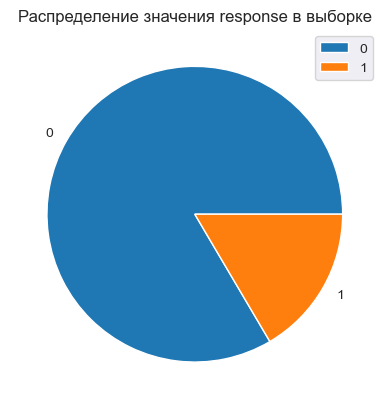

In [89]:
build_response_graph(class_train[class_result])

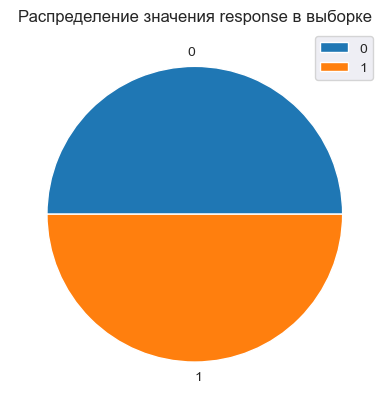

In [90]:
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
build_response_graph(y)

Разобьём выборки на train и test

In [91]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение деревьев решений

In [92]:
def test_tree_parameters(parameters, is_depth):
    """
    Отбирает лучшие параметры модели
    :param parameters:
    :param is_depth:
    :return:
    """
    train_acc = []
    test_acc = []
    cross_val_acc = []
    clfs = []
    for parameter in parameters:
        if is_depth:
            clf = DecisionTreeClassifier(max_depth=parameter)
        else:
            clf = DecisionTreeClassifier(ccp_alpha=parameter, criterion="entropy", max_depth=5)
        clfs.append(clf)
        clf.fit(x_train_c, y_train_c)
        y_pred_train = clf.predict(x_train_c)
        y_pred_test = clf.predict(x_test_c)
        train_acc.append(accuracy_score(y_train_c, y_pred_train))
        test_acc.append(accuracy_score(y_test_c, y_pred_test))
        cr = cross_val_score(clf, class_train[class_all], class_train[class_result])[0]
        cross_val_acc.append(cr)
    best_index = test_acc.index(max(test_acc))
    best_clf = clfs[best_index]
    print(f"The best model: {best_clf}")
    plot_accuracy_graph(max_depth_list, train_acc, test_acc, cross_val_acc)
    return best_clf

In [93]:
def plot_tree_image(data, features, file_name):
    """
    Визуализирует дерево и сохраняет его в виде изображения
    :param data:
    :param features:
    :param file_name:
    :return:
    """
    dot_data = StringIO()
    export_graphviz(data, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=features, class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(file_name)
    img = Image(graph.create_png())
    display(img)

In [94]:
def plot_accuracy_graph(max_depth_list, train_acc, test_acc, cross_acc):
    """
    Строит график зависимости точности от параметров модели
    :param max_depth_list:
    :param train_acc:
    :param test_acc:
    :param cross_acc:
    :return:
    """
    plt.plot(max_depth_list, train_acc, label="Train")
    plt.plot(max_depth_list, test_acc, label="Test")
    plt.plot(max_depth_list, cross_acc, label="Cross validation")
    plt.xlabel("Max depth")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Max depth")
    plt.legend()
    plt.show()

### Классификация

The best model: DecisionTreeClassifier(max_depth=19)


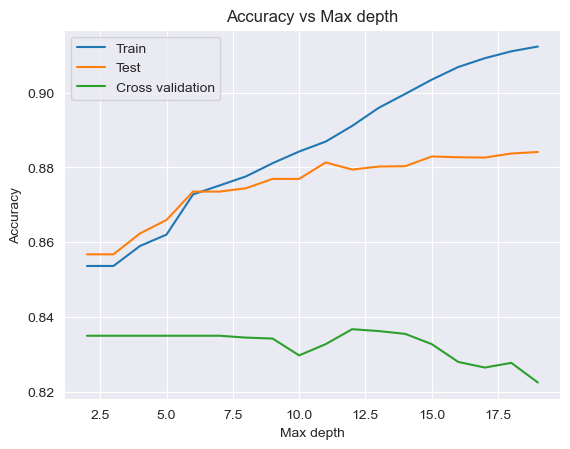

In [95]:
max_depth_list = range(2, 20)
model = test_tree_parameters(max_depth_list, 1);

In [96]:
plot_tree_image(model, class_all, "class_tree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.494164 to fit

(process:10596): GLib-GIO-WARNING **: 22:16:00.583: Unexpectedly, UWP app `36059XiaoyaStudio.RealeBooksReader_2.1.4.0_x86__ngh7ertwt50re' (AUMId `36059XiaoyaStudio.RealeBooksReader_ngh7ertwt50re!REALEBOOKSREADER') supports 32 extensions but has no verbs

(process:10596): GLib-GIO-WARNING **: 22:16:00.805: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.494164 to fit

(process:10532): GLib-GIO-WARNING **: 22:16:05.589: Unexpectedly, UWP app `36059XiaoyaStudio.RealeBooksReader_2.1.4.0_x86__ngh7ertwt50re' (AUMId `36059XiaoyaStudio.RealeBooksReader_ngh7ertwt50re!REALEBOOKSREADER') supports 32 extensions but has no verbs

(process:10532): GLib-GIO-WARNING **: 22:16:05.808: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.15.0_neutral__

### Регрессия

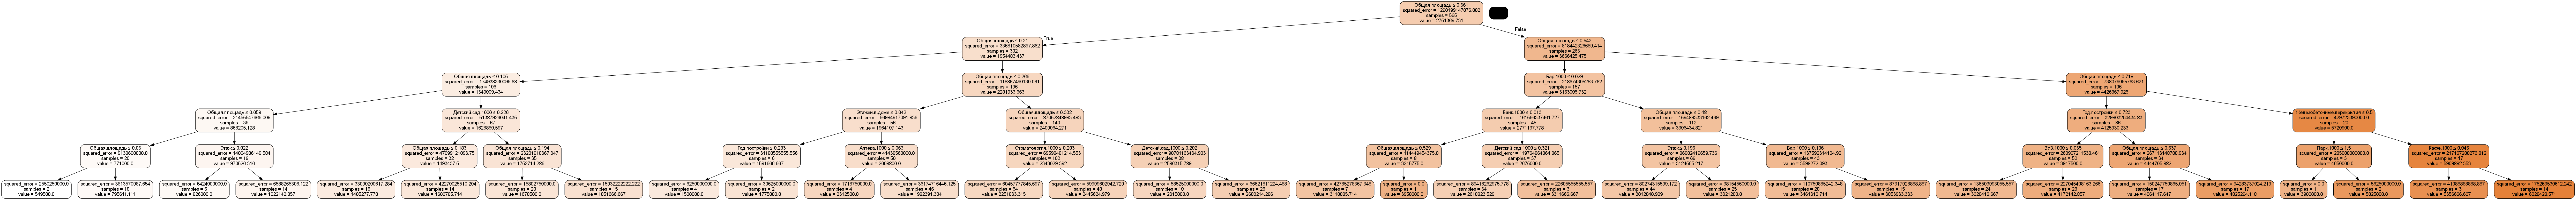

In [97]:
clf = DecisionTreeRegressor(max_depth=5)
clf = clf.fit(x_train_r, y_train_r)
plot_tree_image(clf, regression_all, "regression_tree.png")

## Обрезка деревьев

The best model: DecisionTreeClassifier(ccp_alpha=2, criterion='entropy', max_depth=5)


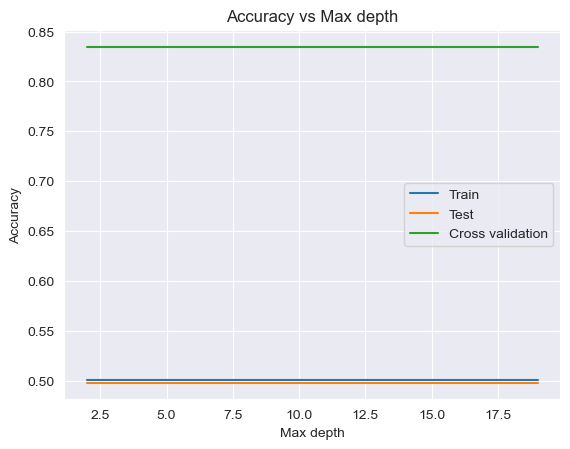

In [98]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_c, y_train_c)
ccp_alphas = path.ccp_alphas
model = test_tree_parameters(max_depth_list, 0);